In [6]:
import os
import cv2
import numpy as np

folder= r"C:\Users\ZenBook\Desktop\machine_learning\images"
image_array=[]

for filename in os.listdir(folder):
    input_path=os.path.join(folder, filename)
    image=cv2.imread(input_path)
    if image is None:
        print("image not found")
        continue
image_array.append(np.array(image))




image not found
image not found
image not found


Here we will define a class for a custom dataset.

In [40]:
import os
import cv2
import numpy as np
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt



class CustomImageDataset(Dataset):
    """
    Class for custom dataset. It is meant to support creating a new dataset using locally stored images that are labeled in a dataframe.
    """
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        """
        The inputs : annotation_file is a dataframe and img_dir is a path. 
        annotation_file should have on the first column the image_id (for example 14446.jpg) that represents the name under which the images is saved. On the second column should be the labels.
        img_dir is the path to the directory where the images are saved.
        Function intitialises the object.
        """
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        """
        Returns the dimension of the dataset.
        """
        return len(self.img_labels)

    def __getitem__(self, idx):
        """
        Parameter idx is an integer. Function returns the image stored as tensor and its type, corresponding to the index idx of the dataframe.
        """
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label



We have previosly created an csv file that contains the image_id and the answers to questions t01, t07 and t02 as weighted factors, for each image. See repository gz2_t01.csv. The code creates a new dataframe which labels every image to a main type (for question t01) according to the format used in the CustomImageDataset class.

In [73]:
img_dir=r"C:\Users\ZenBook\Desktop\machine_learning\images"
csv_file=r"C:\Users\ZenBook\Desktop\machine_learning\gz2_t01.csv"

file=pd.read_csv(csv_file)
file['id'] = file['id'].astype(str) + ".jpg"

for ind in file.index:
    input_path=os.path.join(img_dir, file['id'][ind])
    photo=cv2.imread(input_path)
    if photo is None:
        file.drop(ind, inplace=True)
        

In [75]:
file.loc [file['t01_a01_smooth_weighted_fraction']>0.6, 't01_type'] = 0
file.loc [file['t01_a02_features_or_disk_weighted_fraction']>0.6, 't01_type'] = 1
file.loc [file['t01_a03_star_or_artifact_weighted_fraction']>=0.5, 't01_type'] = 2
 
file.dropna(inplace=True)
file.reset_index(drop=True, inplace=True)

t01_file=file[['id','t01_type']].copy()

print(t01_file)


                id  t01_type
0        58957.jpg       1.0
1       193641.jpg       1.0
2       110937.jpg       0.0
3        37601.jpg       0.0
4        71800.jpg       0.0
...            ...       ...
197962   74398.jpg       0.0
197963  151540.jpg       0.0
197964  259387.jpg       0.0
197965  150542.jpg       0.0
197966  288958.jpg       0.0

[197967 rows x 2 columns]


We create the dataset and check a few images and labels. With this dataset we will train the network to answer the first question t01 and to classify the galaxies.

1.0
1.0
0.0
0.0


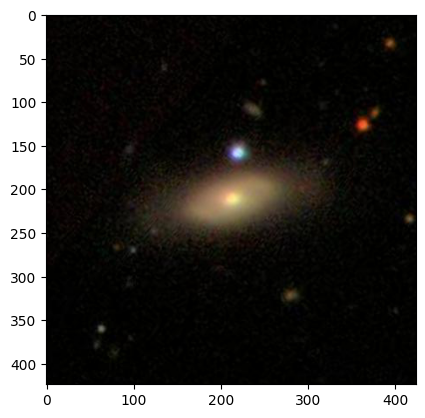

In [71]:
t01_galaxies = CustomImageDataset (t01_file , img_dir)
for i in range(4):
   image, label= t01_galaxies.__getitem__(i)
   plt.imshow(  image.permute(1, 2, 0)  )
   print( label)